# Fixing Giles *et al* 2016 ECARR Implementation

So while I caught the strange band usage in EWDI1 and EWDI2 I absolutely missed the substitution of Modis band 2 for R<sub>672</sub>
where band 1 clearly made more sense.  To rectifiy the issue, we start with pulling in the familar chip of imagery south of Canungra.

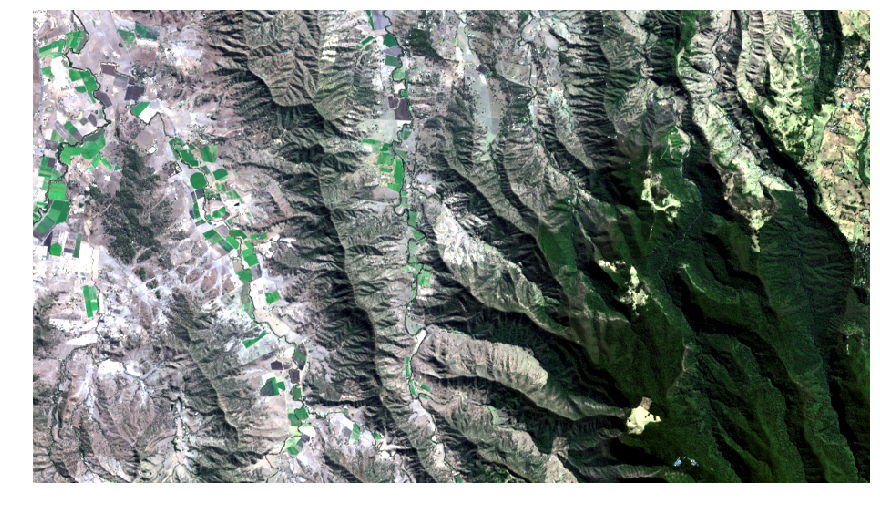

In [60]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
#from shapely.geometry import box
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', 'LC80890792018211LGN00') # image from 7/31/2018
bbox = env.inputs.get('bbox', '152.91389465332034, -28.23725437768062, 153.19473266601562, -28.09681795755814')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=15, h=12)

In [61]:
# Small function to plot figures with colorbars:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def mplot(image, w=15, h=12, cmap='jet'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()

Below we make the obviously appropriate fix suggested, using a band equivalent to MODIS band 1 in the ECARR numerator. 

In [62]:
import numpy as np

# A function to calculate ECARR index as per Giles et al., 2016:
def calc_ecarr_wrong_band(img):
    data_ecarr = img.read([3,4,5,6,2]).astype(np.float32)
    lsband4 = data_ecarr[0,:,:] # 3 Red
    lsband5 = data_ecarr[1,:,:] # 4 NIR
    lsband6 = data_ecarr[2,:,:] # 5 SWIR 1 
    lsband7 = data_ecarr[3,:,:] # 6 SWIR 2
    lsband3 = data_ecarr[4,:,:] # 2 Green

    # Renaming Landsat8 bands to MODIS bands:
    band1 = lsband4
    band2 = lsband5
    band4 = lsband3
    band6 = lsband6
    band7 = lsband7

    ecarr = 0.0161 * ((band2 / (band4 * band1) ) ** 0.7784)
    return(ecarr)
   

# A function to calculate ECARR index, substituting LS8 Band 3 for Modis Band 1:
def calc_ecarr_using_band1(img):
    data_ecarr = img.read([3,2]).astype(np.float32)
    lsband4 = data_ecarr[0,:,:] # 3 Red
    lsband3 = data_ecarr[1,:,:] # 2 Green

    # Renaming Landsat8 bands to MODIS bands:
    band1 = lsband4
    band4 = lsband3
    ecarr = 0.0161 * ((band1 / (band4 * band1) ) ** 0.7784)
    return(ecarr)


As noted previously, the agricultural fields scored very highly on the ECARR index, something which should have given me more pause than it did.

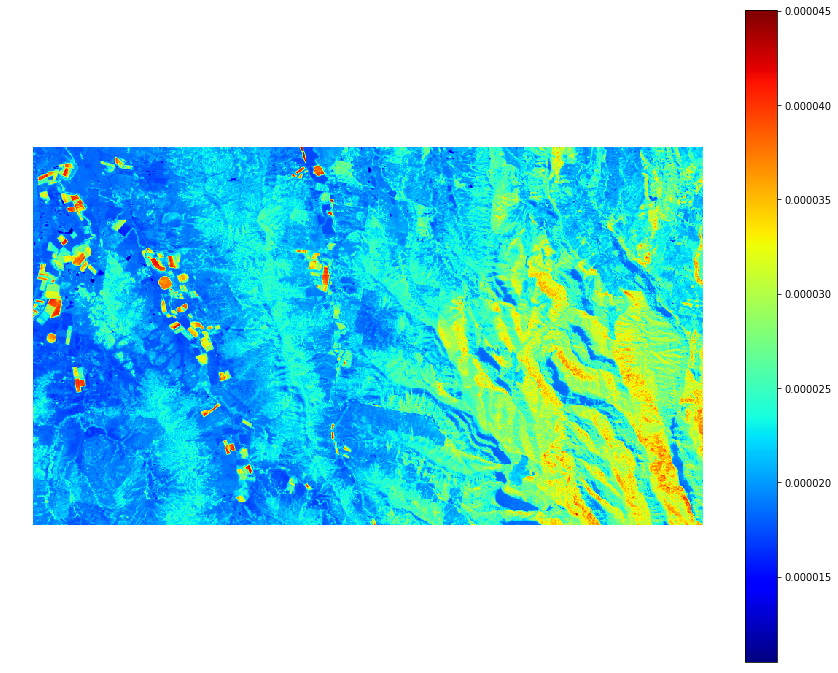

In [63]:
ecarr = calc_ecarr_wrong_band(image) # Using our original implementation of Giles et al.'s "typo'd" ECARR
mplot(ecarr)

Fixing the ECARR formula has the agreeable effect of evaluating the agricultural fields as having less eucalypt growth than the eucalyptus forests that lie to their east.


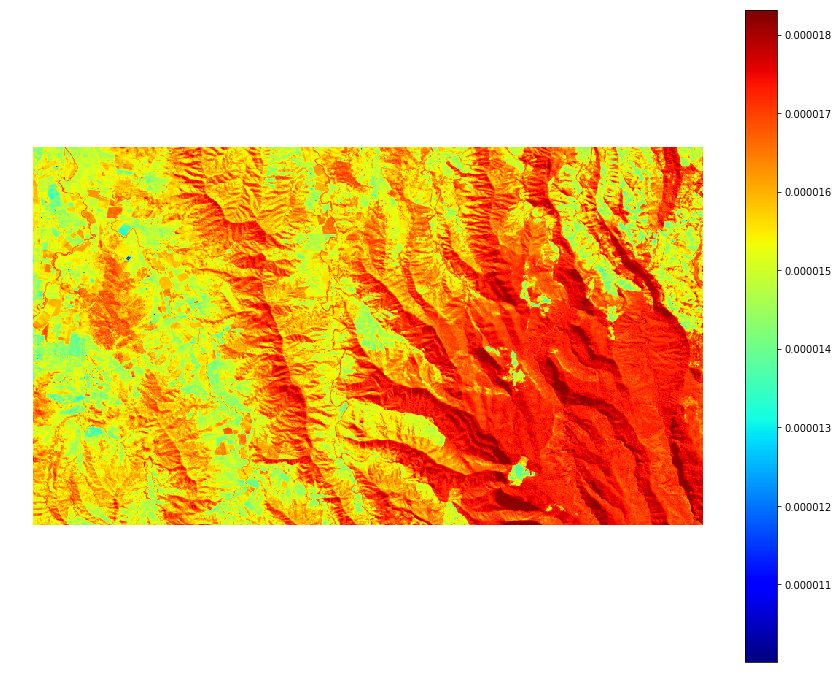

In [8]:
ecarr2 = calc_ecarr_using_band1(image) # Using Band1 instead of Band2 in the numerator
mplot(ecarr2)